**g16**
- anderdav@students.zhaw.ch
- goodnic1@students.zhaw.ch
- janick.rueegger@students.fhnw.ch
- neyerjoh@students.zhaw.ch

# Exercise 2: Shallow networks on CIFAR10

In [1]:
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
from math import ceil, sqrt
import numpy as np
rng = np.random.default_rng()

In [2]:
Transform = ToTensor()

train_data = datasets.CIFAR10(
    root = "../data",
    train = True,                         
    transform = Transform, 
    download = True,            
)

test_data = datasets.CIFAR10(
    root = "../data", 
    train = False, 
    transform = Transform,
    download = True
)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()

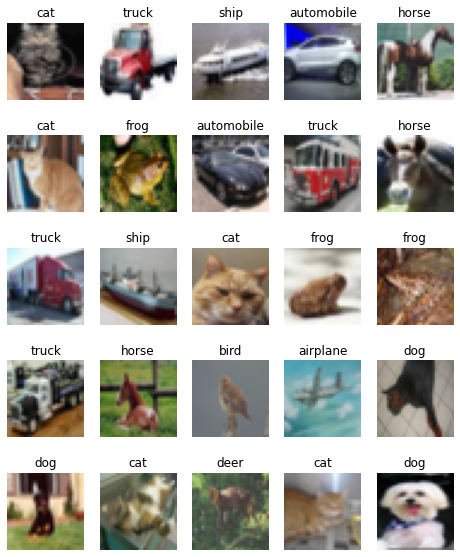

In [5]:
def show_imgs(X):
    figure = plt.figure(figsize=(8, 10))
    cols, rows = 5, 5
    for i in range(1, cols * rows + 1):
        img, label = X[rng.integers(len(X))]
        figure.add_subplot(rows, cols, i)
        plt.title(X.classes[label])
        plt.axis("off")
        plt.imshow(img.permute(1,2,0))
    plt.show()
    
show_imgs(train_data)

In [6]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

n_classes = len(train_data.classes)
input_size = np.prod(train_data.data.shape[1:])

In [7]:
def train(epoch, model, data_loader, log_interval=200):
    
    model.train()
    
    total_train_loss = 0
    total_correct = 0
    
    for batch_idx, (data, target) in enumerate(tqdm(data_loader, desc=f"Training Epoch {epoch}")):
        
        optimizer.zero_grad()
        
        output = model(data)
        
        loss = criterion(output, target)

        loss.backward()
        
        optimizer.step()
        
        total_train_loss += loss.item()
        
        pred = output.argmax(dim=1)
        
        total_correct += torch.sum(pred == target).item()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{:5}/{:5} ({:2.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()))

    accuracy_train = total_correct / len(data_loader.dataset)

    total_train_loss = total_train_loss / len(data_loader)

    return {
        "loss": total_train_loss,
        "accuracy": accuracy_train,
    }

In [8]:
@torch.inference_mode()
def validate(model, data_loader):
   
    model.eval()
    
    val_loss = 0
    total_correct = 0
    total_preds = []
    total_targets = []
    
    for data, target in tqdm(data_loader, desc="Validation"):
        output = model(data)
        val_loss += criterion(output, target).item()
        
        pred = output.argmax(dim=1)
        total_correct += torch.sum(pred == target).item()
        total_preds.append(pred.detach().cpu())
        total_targets.append(target.cpu())

    val_loss /= len(data_loader)
    accuracy = total_correct / len(data_loader.dataset)
    
    print("Validation set: Average loss: {:.4f}, Accuracy: {:5}/{:5} ({:2.2f}%)\n".format(
        val_loss, total_correct, len(data_loader.dataset), 100 * accuracy))
    
    return {
        "loss": val_loss,
        "accuracy": accuracy,
        "predictions": torch.cat(total_preds),
        "targets": torch.cat(total_targets),
    }

## One-Layer Network

In [9]:
model = nn.Sequential(
    nn.Flatten(), # needed when using Sequential
    nn.Linear(input_size, n_classes))
    #nn.Softmax(dim=0)) # not needed when crossentropyloss is used

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.05)

summary(model, input_size=(1, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                   [-1, 10]          30,730
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 0.12
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


In [10]:
%%time

epochs = 5

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, epochs + 1):
    train_result = train(epoch, model, train_loader)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])
    
    val_result = validate(model, test_loader)
    val_losses.append(val_result["loss"])
    val_accuracies.append(val_result["accuracy"])

Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 1 [    0/50000 ( 0%)]	Loss: 2.333400
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.901711


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.8495, Accuracy:  3584/10000 (35.84%)



Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 2 [    0/50000 ( 0%)]	Loss: 1.731730
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.865132


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.8964, Accuracy:  3274/10000 (32.74%)



Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 3 [    0/50000 ( 0%)]	Loss: 1.955293
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.891398


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.8592, Accuracy:  3493/10000 (34.93%)



Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 4 [    0/50000 ( 0%)]	Loss: 1.845174
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.834723


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.8319, Accuracy:  3732/10000 (37.32%)



Training Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 5 [    0/50000 ( 0%)]	Loss: 1.797484
Train Epoch: 5 [25600/50000 (51%)]	Loss: 1.893015


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.8203, Accuracy:  3628/10000 (36.28%)

CPU times: user 1min 12s, sys: 137 ms, total: 1min 13s
Wall time: 23.5 s


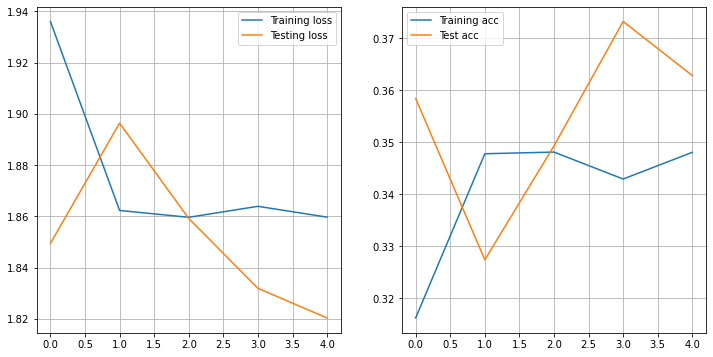

In [11]:
f = plt.figure(figsize=(12,6))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Testing loss')
ax1.legend()
ax1.grid()

ax2.plot(train_accuracies, label='Training acc')
ax2.plot(val_accuracies, label='Test acc')
ax2.legend()
ax2.grid()

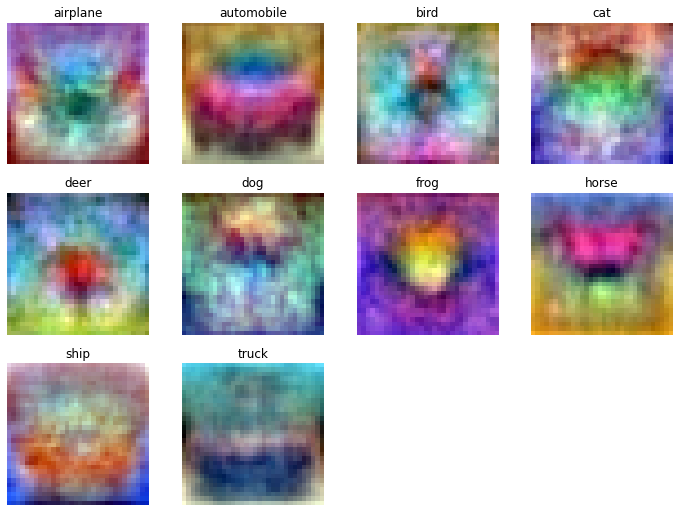

In [12]:
classifier_weight = dict(model.named_parameters())["1.weight"].detach().clone()

fig = plt.figure(figsize=(12,12))

cols = rows = int(ceil(sqrt(n_classes)))

for i, weight in enumerate(classifier_weight):
    ax = fig.add_subplot(rows, cols, 1+i)
    img = weight.reshape(train_data[0][0].shape)
    for channel in img:
        channel -= channel.min()
        channel *= 255 / channel.max()
    ax.axis('off')
    plt.title(train_data.classes[i])
    ax.imshow(img.type(torch.int64).permute(1,2,0))

## Two-Layer Network

In [13]:
n_hidden_layer_neurons = 256

model = nn.Sequential(
    nn.Flatten(), # needed when using Sequential
    nn.Linear(input_size, n_hidden_layer_neurons),
    nn.ReLU(),
    nn.Linear(n_hidden_layer_neurons, n_hidden_layer_neurons),
    nn.ReLU(),
    nn.Linear(n_hidden_layer_neurons, n_classes))
    #nn.Softmax(dim=0)) # not needed when crossentropyloss is used

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.AdamW(model.parameters())

summary(model, input_size=(1, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                  [-1, 256]         786,688
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 256]          65,792
              ReLU-5                  [-1, 256]               0
            Linear-6                   [-1, 10]           2,570
Total params: 855,050
Trainable params: 855,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 3.26
Estimated Total Size (MB): 3.30
----------------------------------------------------------------


In [14]:
%%time

epochs = 15

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, epochs + 1):
    train_result = train(epoch, model, train_loader)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])
    
    val_result = validate(model, test_loader)
    val_losses.append(val_result["loss"])
    val_accuracies.append(val_result["accuracy"])

Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 1 [    0/50000 ( 0%)]	Loss: 2.303396
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.766781


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.7304, Accuracy:  3890/10000 (38.90%)



Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 2 [    0/50000 ( 0%)]	Loss: 1.694436
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.633952


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.5989, Accuracy:  4316/10000 (43.16%)



Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 3 [    0/50000 ( 0%)]	Loss: 1.595137
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.546891


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.5460, Accuracy:  4476/10000 (44.76%)



Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 4 [    0/50000 ( 0%)]	Loss: 1.710233
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.669782


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.5458, Accuracy:  4508/10000 (45.08%)



Training Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 5 [    0/50000 ( 0%)]	Loss: 1.599523
Train Epoch: 5 [25600/50000 (51%)]	Loss: 1.427818


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.5316, Accuracy:  4630/10000 (46.30%)



Training Epoch 6:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 6 [    0/50000 ( 0%)]	Loss: 1.682112
Train Epoch: 6 [25600/50000 (51%)]	Loss: 1.518739


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.4559, Accuracy:  4808/10000 (48.08%)



Training Epoch 7:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 7 [    0/50000 ( 0%)]	Loss: 1.378856
Train Epoch: 7 [25600/50000 (51%)]	Loss: 1.261373


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.4315, Accuracy:  4937/10000 (49.37%)



Training Epoch 8:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 8 [    0/50000 ( 0%)]	Loss: 1.397580
Train Epoch: 8 [25600/50000 (51%)]	Loss: 1.516747


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.4276, Accuracy:  4874/10000 (48.74%)



Training Epoch 9:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 9 [    0/50000 ( 0%)]	Loss: 1.572854
Train Epoch: 9 [25600/50000 (51%)]	Loss: 1.395977


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.4466, Accuracy:  4861/10000 (48.61%)



Training Epoch 10:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 10 [    0/50000 ( 0%)]	Loss: 1.365649
Train Epoch: 10 [25600/50000 (51%)]	Loss: 1.295902


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.4045, Accuracy:  5064/10000 (50.64%)



Training Epoch 11:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 11 [    0/50000 ( 0%)]	Loss: 1.144563
Train Epoch: 11 [25600/50000 (51%)]	Loss: 1.348123


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.4113, Accuracy:  5010/10000 (50.10%)



Training Epoch 12:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 12 [    0/50000 ( 0%)]	Loss: 1.278603
Train Epoch: 12 [25600/50000 (51%)]	Loss: 1.364331


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.3984, Accuracy:  4994/10000 (49.94%)



Training Epoch 13:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 13 [    0/50000 ( 0%)]	Loss: 1.330599
Train Epoch: 13 [25600/50000 (51%)]	Loss: 1.163625


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.3935, Accuracy:  5033/10000 (50.33%)



Training Epoch 14:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 14 [    0/50000 ( 0%)]	Loss: 1.267805
Train Epoch: 14 [25600/50000 (51%)]	Loss: 1.331899


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.3943, Accuracy:  5130/10000 (51.30%)



Training Epoch 15:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 15 [    0/50000 ( 0%)]	Loss: 1.168905
Train Epoch: 15 [25600/50000 (51%)]	Loss: 1.119143


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.3863, Accuracy:  5059/10000 (50.59%)

CPU times: user 7min 33s, sys: 387 ms, total: 7min 33s
Wall time: 1min 47s


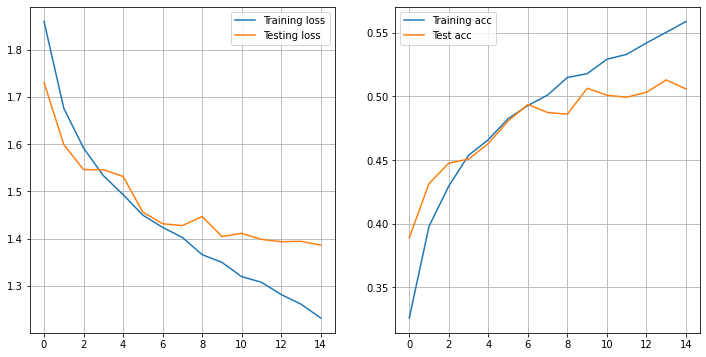

In [15]:
f = plt.figure(figsize=(12,6))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Testing loss')
ax1.legend()
ax1.grid()

ax2.plot(train_accuracies, label='Training acc')
ax2.plot(val_accuracies, label='Test acc')
ax2.legend()
ax2.grid()